# Comprehensive Model Evaluation Across MVTec Categories

This notebook evaluates all autoencoder models (CAE, VAE, ViT-VAE, VAE-GRF) across multiple categories from the MVTec AD dataset and provides comprehensive performance summaries.

In [59]:
! pip install torch matplotlib numpy pandas pytorch_lightning scikit-learn torchvision seaborn

In [60]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from load_dataset import get_mvtec_loader
from CAE import CAE
from VAE import VAE
from ViTVAE import ViTVAE
from VAE_GRF import VAE_GRF

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [61]:
# Configuration
BATCH_SIZE = 32
IMAGE_SIZE = 256
ROOT_DIR = '../mvtec_anomaly_detection'
MAX_EPOCHS = 50

# Categories to evaluate
CATEGORIES = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 
              'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 
              'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

# You can reduce this list for faster testing
# CATEGORIES = ['bottle', 'cable', 'capsule']

In [62]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate a model and return anomaly scores and metrics.
    """
    model.eval()
    model.to(device)
    
    anomaly_scores = []
    true_labels = []
    
    criterion = nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            
            # Handle different model outputs
            if isinstance(model, CAE):
                outputs = model(images)
            else:  # VAE, ViTVAE, VAE_GRF
                outputs, _, _ = model(images)
            
            loss = criterion(outputs, images)
            loss = loss.view(loss.size(0), -1).mean(dim=1)
            
            anomaly_scores.extend(loss.cpu().numpy())
            true_labels.extend(labels.numpy())
    
    anomaly_scores = np.array(anomaly_scores)
    true_labels = np.array(true_labels)
    
    # Calculate metrics
    roc_auc = roc_auc_score(true_labels, anomaly_scores)
    
    # Calculate best threshold using F1 score
    precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores[:-1])]
    
    # Get predictions with best threshold
    predictions = (anomaly_scores > best_threshold).astype(int)
    
    # Calculate precision, recall, F1 at best threshold
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision_val = precision_score(true_labels, predictions)
    recall_val = recall_score(true_labels, predictions)
    f1_val = f1_score(true_labels, predictions)
    
    return {
        'roc_auc': roc_auc,
        'precision': precision_val,
        'recall': recall_val,
        'f1_score': f1_val,
        'best_threshold': best_threshold
    }

In [63]:
def train_and_evaluate_all_models(category, max_epochs=MAX_EPOCHS):
    """
    Train and evaluate all models on a specific category.
    """
    print(f"\n{'='*60}")
    print(f"Processing Category: {category.upper()}")
    print(f"{'='*60}")
    
    # Load data
    train_loader = get_mvtec_loader(ROOT_DIR, category, batch_size=BATCH_SIZE, 
                                    image_size=IMAGE_SIZE, split='train')
    test_loader = get_mvtec_loader(ROOT_DIR, category, batch_size=BATCH_SIZE, 
                                   image_size=IMAGE_SIZE, split='test')
    
    print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")
    
    results = {}
    
    # Model configurations
    models_config = [
        ('CAE', lambda: CAE(input_channels=3, lr=1e-3)),
        ('VAE', lambda: VAE(input_channels=3, latent_dim=1024, lr=1e-3)),
        ('ViT-VAE', lambda: ViTVAE(image_size=IMAGE_SIZE, patch_size=32, input_channels=3, 
                                   dim=256, depth=4, heads=4, mlp_dim=512, latent_dim=512, lr=1e-3)),
        ('VAE-GRF', lambda: VAE_GRF(input_channels=3, latent_channels=16, lr=1e-3))
    ]
    
    for model_name, model_constructor in models_config:
        print(f"\n--- Training {model_name} ---")
        
        try:
            # Initialize model
            model = model_constructor()
            
            # Train model
            trainer = pl.Trainer(
                max_epochs=max_epochs,
                accelerator="auto",
                devices=1,
                enable_progress_bar=True,
                enable_model_summary=False,
                logger=False
            )
            trainer.fit(model, train_loader)
            
            # Evaluate model
            print(f"Evaluating {model_name}...")
            metrics = evaluate_model(model, test_loader, device)
            results[model_name] = metrics
            
            print(f"{model_name} Results:")
            print(f"  ROC AUC: {metrics['roc_auc']:.4f}")
            print(f"  F1 Score: {metrics['f1_score']:.4f}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            
            # Clean up memory
            del model
            del trainer
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"Error training/evaluating {model_name}: {str(e)}")
            results[model_name] = {
                'roc_auc': np.nan,
                'precision': np.nan,
                'recall': np.nan,
                'f1_score': np.nan,
                'best_threshold': np.nan
            }
    
    return results

In [64]:
import json
import os
from datetime import datetime

# File to save incremental results
RESULTS_FILE = 'evaluation_results_incremental.json'

def load_previous_results():
    """Load previously saved results if they exist."""
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            return json.load(f)
    return {}

def convert_to_serializable(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (np.float32, np.float64)):
        val = float(obj)
        # Replace NaN with None (null in JSON)
        return None if np.isnan(val) else val
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    # Handle regular Python float NaN
    elif isinstance(obj, float) and np.isnan(obj):
        return None
    return obj

def save_results(all_results):
    """Save current results to file."""
    # Convert numpy types to native Python types
    serializable_results = convert_to_serializable(all_results)
    with open(RESULTS_FILE, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Results saved to {RESULTS_FILE}")

def get_remaining_categories(all_categories, completed_results):
    """Get list of categories that haven't been evaluated yet."""
    completed = set(completed_results.keys())
    remaining = [cat for cat in all_categories if cat not in completed]
    return remaining

In [65]:
# Load any previous results
all_results = load_previous_results()

# Get remaining categories to process
remaining_categories = get_remaining_categories(CATEGORIES, all_results)

if len(all_results) > 0:
    print(f"Found {len(all_results)} previously completed categories")
    print(f"Remaining categories to process: {remaining_categories}")
else:
    print(f"Starting fresh evaluation of all {len(CATEGORIES)} categories")

print(f"\nCategories to process in this run: {remaining_categories}")

Found 15 previously completed categories
Remaining categories to process: []

Categories to process in this run: []


## Individual Category Evaluation

Each category is evaluated in a separate cell below. This allows you to:
- Run one category at a time to avoid crashes
- Resume from any point if the process is interrupted
- Results are automatically saved after each category completes

**Note:** Results from previous runs are loaded automatically. If a category is already completed, you can skip that cell.

In [66]:
# Evaluate: bottle
category = 'bottle'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

bottle already completed. Skipping...


In [67]:
# Evaluate: cable
category = 'cable'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

cable already completed. Skipping...


In [68]:
# Evaluate: capsule
category = 'capsule'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

capsule already completed. Skipping...


In [69]:
# Evaluate: carpet
category = 'carpet'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

carpet already completed. Skipping...


In [70]:
# Evaluate: grid
category = 'grid'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

grid already completed. Skipping...


In [71]:
# Evaluate: hazelnut
category = 'hazelnut'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

hazelnut already completed. Skipping...


In [72]:
# Evaluate: leather
category = 'leather'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

leather already completed. Skipping...


In [73]:
# Evaluate: metal_nut
category = 'metal_nut'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

metal_nut already completed. Skipping...


In [74]:
# Evaluate: pill
category = 'pill'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

pill already completed. Skipping...


In [75]:
# Evaluate: screw
category = 'screw'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

screw already completed. Skipping...


In [76]:
# Evaluate: tile
category = 'tile'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

tile already completed. Skipping...


In [77]:
# Evaluate: toothbrush
category = 'toothbrush'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

toothbrush already completed. Skipping...


In [78]:
# Evaluate: transistor
category = 'transistor'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

transistor already completed. Skipping...


In [79]:
# Evaluate: wood
category = 'wood'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

wood already completed. Skipping...


In [80]:
# Evaluate: zipper
category = 'zipper'
if category not in all_results:
    print(f"Processing {category}...")
    category_results = train_and_evaluate_all_models(category)
    all_results[category] = category_results
    save_results(all_results)
else:
    print(f"{category} already completed. Skipping...")

zipper already completed. Skipping...


## Results Summary

The cells below will display the results from all completed categories. Run them after completing one or more categories above.

In [81]:
# Reload results from file (in case you're resuming)
all_results = load_previous_results()

if len(all_results) == 0:
    print("No results found. Please run the evaluation cells above first.")
else:
    # Create comprehensive results dataframe
    results_data = []

    for category, models in all_results.items():
        for model_name, metrics in models.items():
            results_data.append({
                'Category': category,
                'Model': model_name,
                'ROC AUC': metrics['roc_auc'],
                'F1 Score': metrics['f1_score'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall']
            })

    results_df = pd.DataFrame(results_data)
    print("\n" + "="*80)
    print("COMPLETE RESULTS")
    print("="*80)
    print(f"Results for {len(all_results)} categories:")
    print(results_df.to_string(index=False))


COMPLETE RESULTS
Results for 15 categories:
  Category   Model  ROC AUC  F1 Score  Precision   Recall
    bottle     CAE 0.603968  0.855172   0.756098 0.984127
    bottle     VAE 0.783333  0.880597   0.830986 0.936508
    bottle ViT-VAE 0.816667  0.880597   0.830986 0.936508
    bottle VAE-GRF 0.693651  0.855172   0.756098 0.984127
     cable     CAE 0.536544  0.755187   0.610738 0.989130
     cable     VAE 0.778673  0.789238   0.671756 0.956522
     cable ViT-VAE 0.667916  0.761506   0.619048 0.989130
     cable VAE-GRF 0.551724  0.755187   0.610738 0.989130
   capsule     CAE 0.535700  0.900000   0.824427 0.990826
   capsule     VAE 0.565217  0.903766   0.830769 0.990826
   capsule ViT-VAE 0.489828  0.900000   0.824427 0.990826
   capsule VAE-GRF 0.503789  0.903766   0.830769 0.990826
    carpet     CAE 0.420144  0.858537   0.758621 0.988764
    carpet     VAE 0.347512  0.858537   0.758621 0.988764
    carpet ViT-VAE 0.360353  0.858537   0.758621 0.988764
    carpet VAE-GRF 0.376806

In [82]:
# Summary statistics by model
summary_by_model = results_df.groupby('Model')[['ROC AUC', 'F1 Score', 'Precision', 'Recall']].agg(['mean', 'std', 'min', 'max'])
print("\n" + "="*80)
print("SUMMARY BY MODEL")
print("="*80)
print(summary_by_model)

# Save to CSV
results_df.to_csv('evaluation_results_all_models.csv', index=False)
summary_by_model.to_csv('summary_by_model.csv')
print("\nResults saved to 'evaluation_results_all_models.csv' and 'summary_by_model.csv'")


SUMMARY BY MODEL
          ROC AUC                                F1 Score                      \
             mean       std       min       max      mean       std       min   
Model                                                                           
CAE      0.603043  0.188737  0.329423  0.914035  0.838965  0.086565  0.561151   
VAE      0.631187  0.207219  0.085058  0.934211  0.846343  0.074270  0.621622   
VAE-GRF  0.574801  0.176004  0.340176  0.950877  0.841416  0.089214  0.561151   
ViT-VAE  0.564704  0.199192  0.237048  0.937719  0.842211  0.073957  0.632911   

                  Precision                                  Recall            \
              max      mean       std       min       max      mean       std   
Model                                                                           
CAE      0.922559  0.748525  0.121530  0.393939  0.906250  0.972842  0.040945   
VAE      0.934426  0.771004  0.070947  0.671756  0.919355  0.945268  0.104059   
VAE-GRF  

<Figure size 1600x800 with 0 Axes>

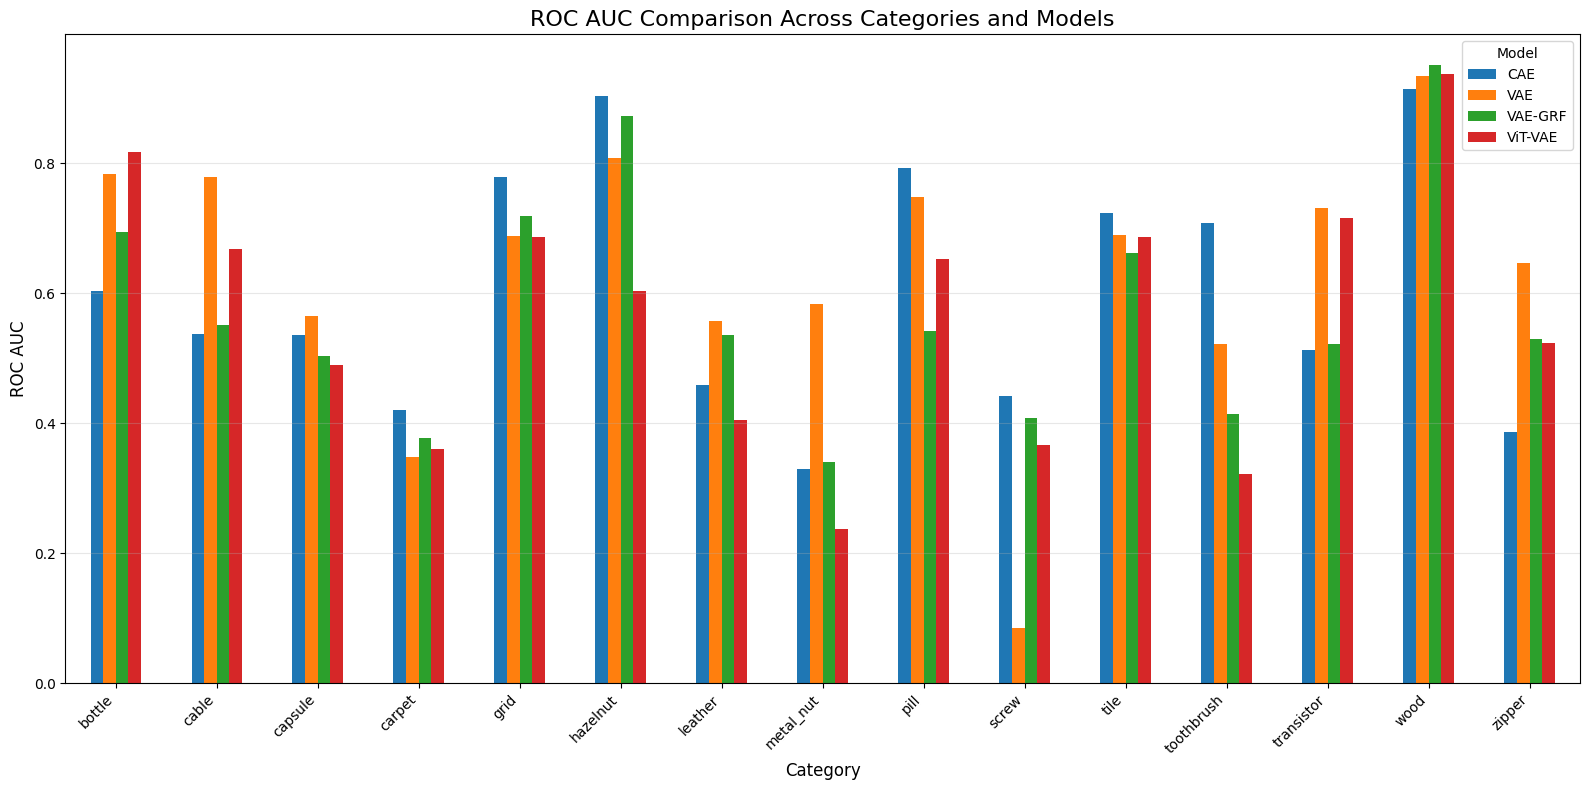

In [83]:
# Visualization: ROC AUC comparison across categories
plt.figure(figsize=(16, 8))
pivot_auc = results_df.pivot(index='Category', columns='Model', values='ROC AUC')
pivot_auc.plot(kind='bar', figsize=(16, 8))
plt.title('ROC AUC Comparison Across Categories and Models', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1600x800 with 0 Axes>

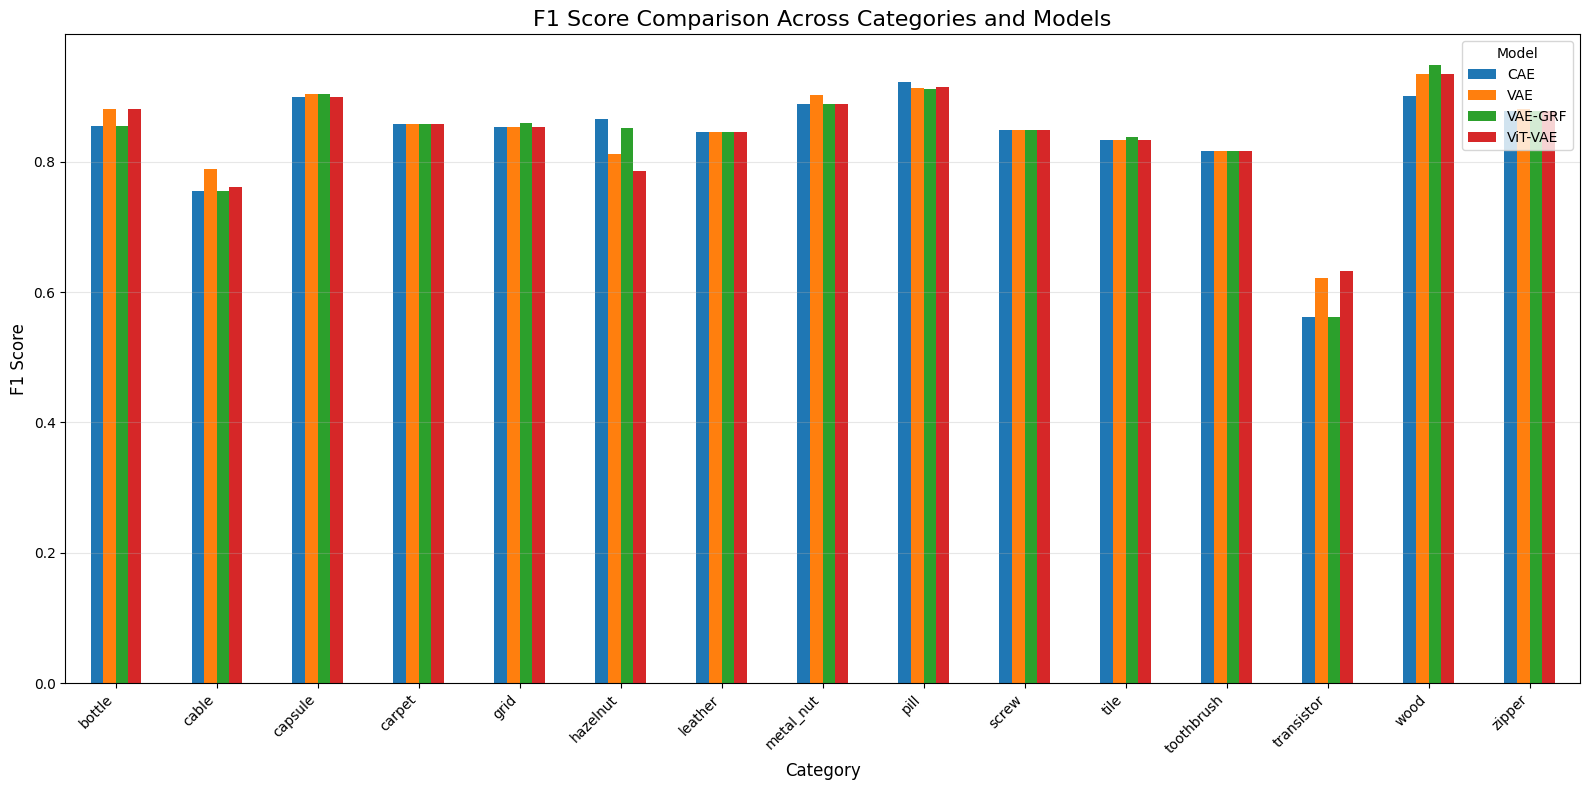

In [84]:
# Visualization: ROC AUC comparison across categories
plt.figure(figsize=(16, 8))
pivot_auc = results_df.pivot(index='Category', columns='Model', values='F1 Score')
pivot_auc.plot(kind='bar', figsize=(16, 8))
plt.title('F1 Score Comparison Across Categories and Models', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1600x800 with 0 Axes>

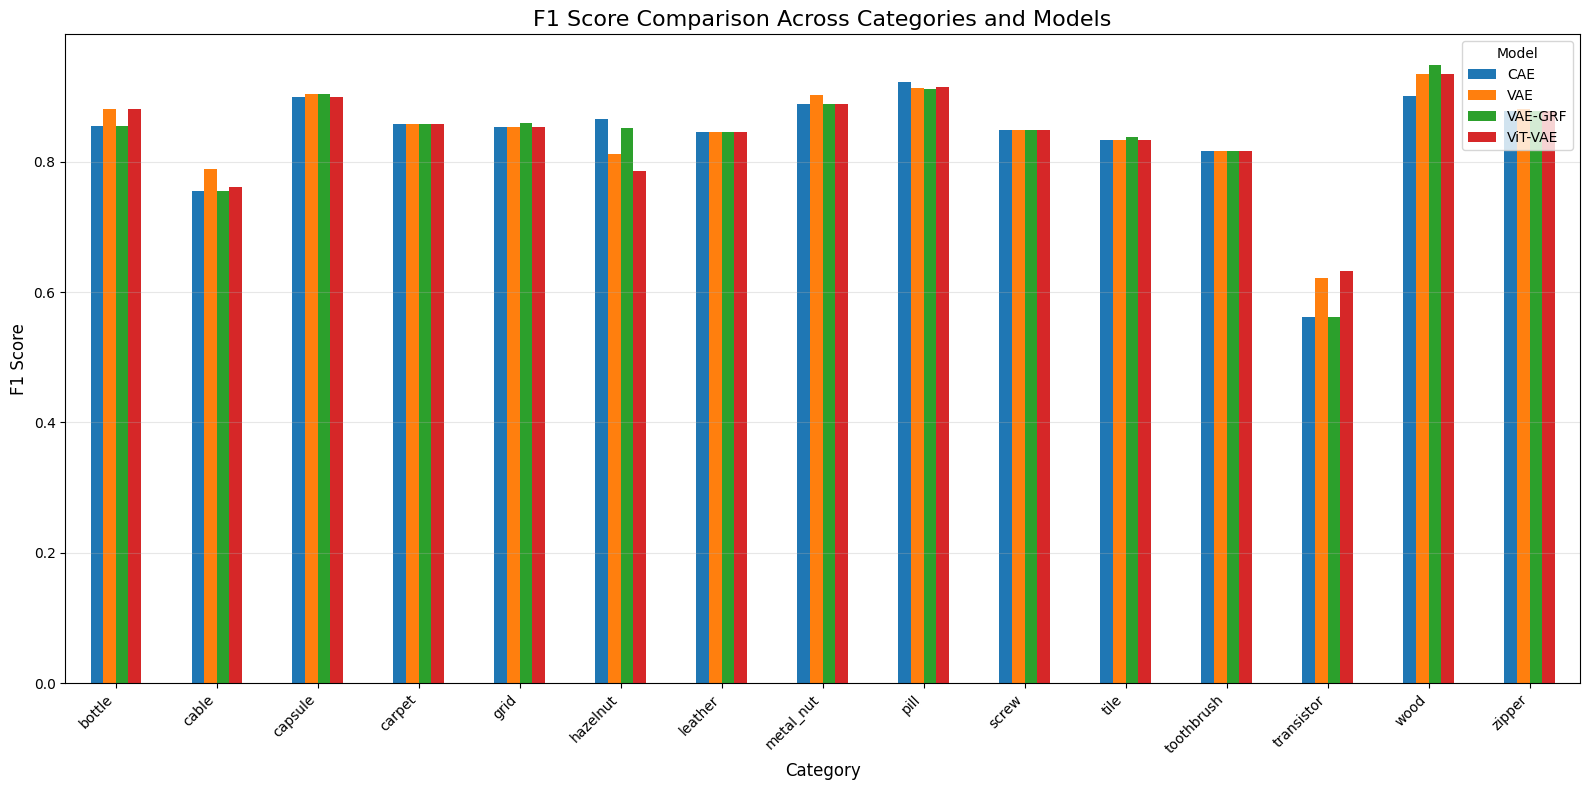

In [54]:
# Visualization: F1 Score comparison
plt.figure(figsize=(16, 8))
pivot_f1 = results_df.pivot(index='Category', columns='Model', values='F1 Score')
pivot_f1.plot(kind='bar', figsize=(16, 8))
plt.title('F1 Score Comparison Across Categories and Models', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Model', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

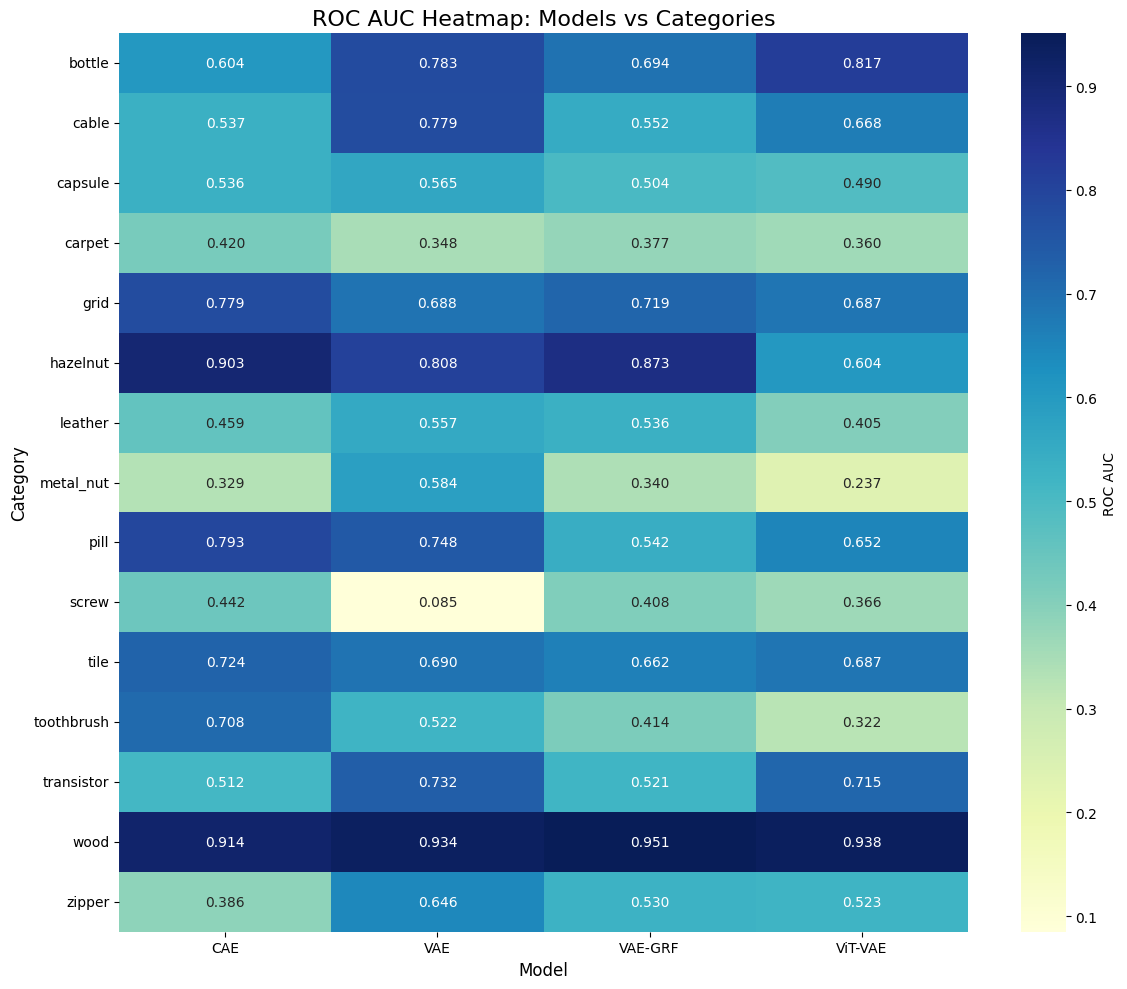

In [55]:
plt.figure(figsize=(12, 10))
pivot_heatmap = results_df.pivot(index='Category', columns='Model', values='ROC AUC')
sns.heatmap(pivot_heatmap, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'ROC AUC'})
plt.title('ROC AUC Heatmap: Models vs Categories', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.savefig('roc_auc_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

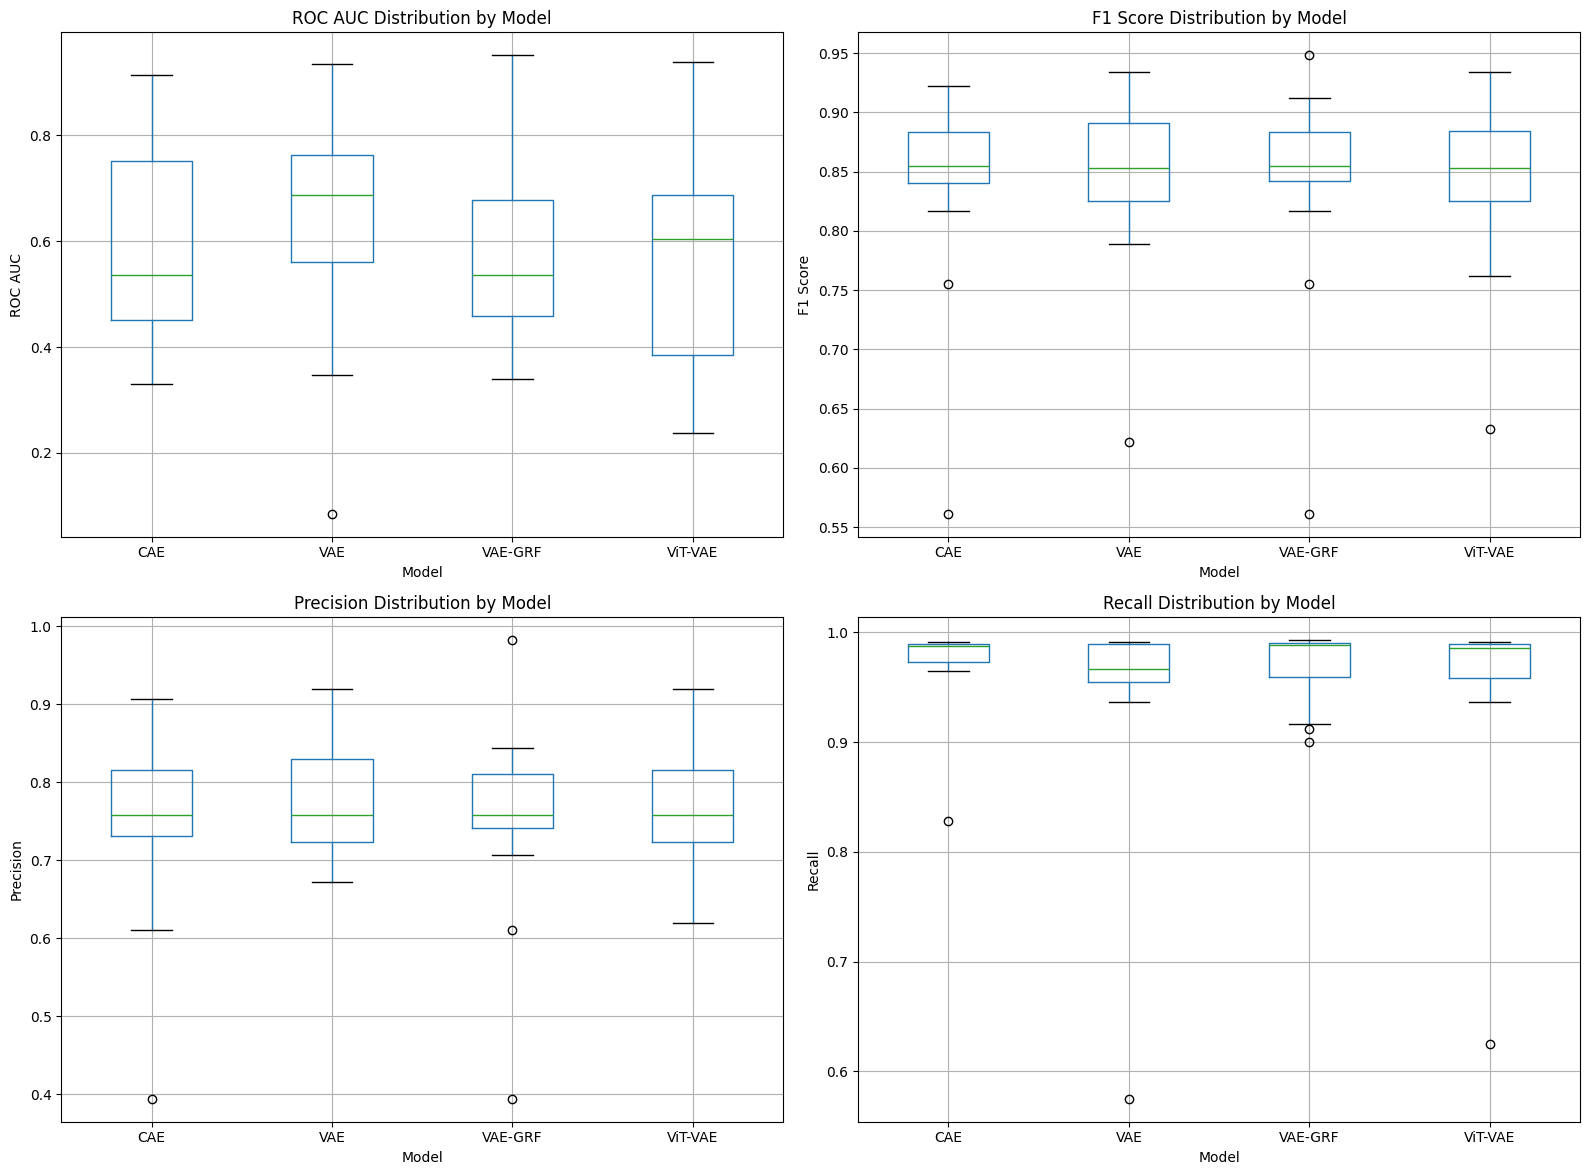

In [56]:
# Box plots for metric distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['ROC AUC', 'F1 Score', 'Precision', 'Recall']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    results_df.boxplot(column=metric, by='Model', ax=ax)
    ax.set_title(f'{metric} Distribution by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.get_figure().suptitle('')

plt.tight_layout()
plt.savefig('metrics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# Best model per category
best_models = results_df.loc[results_df.groupby('Category')['ROC AUC'].idxmax()]
print("\n" + "="*80)
print("BEST MODEL PER CATEGORY (by ROC AUC)")
print("="*80)
print(best_models[['Category', 'Model', 'ROC AUC', 'F1 Score']].to_string(index=False))

# Count wins per model
model_wins = best_models['Model'].value_counts()
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nNumber of categories where each model performed best:")
print(model_wins)

# Overall average rankings
print("\nOverall average metrics across all categories:")
overall_avg = results_df.groupby('Model')[['ROC AUC', 'F1 Score', 'Precision', 'Recall']].mean()
overall_avg = overall_avg.sort_values('ROC AUC', ascending=False)
print(overall_avg)


BEST MODEL PER CATEGORY (by ROC AUC)
  Category   Model  ROC AUC  F1 Score
    bottle ViT-VAE 0.816667  0.880597
     cable     VAE 0.778673  0.789238
   capsule     VAE 0.565217  0.903766
    carpet     CAE 0.420144  0.858537
      grid     CAE 0.779449  0.852713
  hazelnut     CAE 0.902857  0.865672
   leather     VAE 0.556726  0.846512
 metal_nut     VAE 0.584066  0.901961
      pill     CAE 0.792690  0.922559
     screw     CAE 0.441894  0.848921
      tile     CAE 0.723665  0.834171
toothbrush     CAE 0.708333  0.816901
transistor     VAE 0.731667  0.621622
      wood VAE-GRF 0.950877  0.948276
    zipper     VAE 0.646271  0.880597

MODEL PERFORMANCE SUMMARY

Number of categories where each model performed best:
Model
CAE        7
VAE        6
ViT-VAE    1
VAE-GRF    1
Name: count, dtype: int64

Overall average metrics across all categories:
          ROC AUC  F1 Score  Precision    Recall
Model                                           
VAE      0.631187  0.846343   0.771004  0.

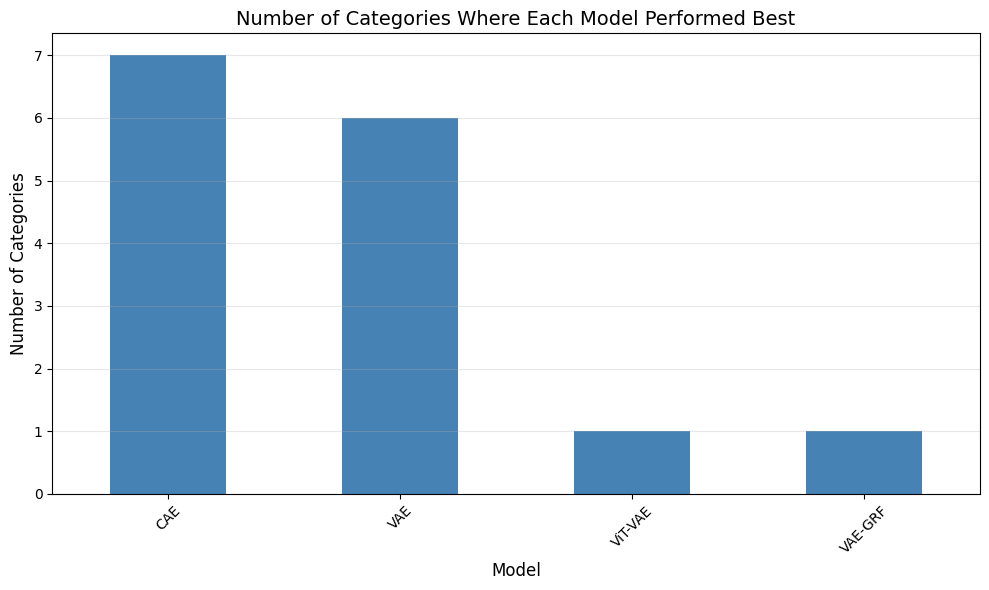

In [58]:
plt.figure(figsize=(10, 6))
model_wins.plot(kind='bar', color='steelblue')
plt.title('Number of Categories Where Each Model Performed Best', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_wins.png', dpi=300, bbox_inches='tight')
plt.show()